In [26]:
import warnings

import numpy as np
import pandas as pd
import torch
warnings.filterwarnings('ignore')

# 气温预测, 使用简单方法
这里使用到的数据是kaggle上的数据 <https://www.kaggle.com/datasets/ns0720/tempscsv>


In [27]:
features = pd.read_csv("../../data/temps.csv")
features.head()


,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2019,1,1,Fri,45,45,45.6,45,29
1,2019,1,2,Sat,44,45,45.7,44,61
2,2019,1,3,Sun,45,44,45.8,41,56
3,2019,1,4,Mon,44,41,45.9,40,53
4,2019,1,5,Tues,41,40,46.0,44,41


在数据表中:
- year,moth,day,week分别表示的具体的时间
- temp_2：前天的最高温度值
- temp_1：昨天的最高温度值
- average：在历史中，每年这一天的平均最高温度值
- actual：标签值，当天的真实最高温度
- friend: 朋友猜测的可能性, 过滤掉

In [28]:
print('数据维度:',features.shape) # 348 行 9 列

数据维度: (348, 9)


In [29]:
import datetime

# 进行数据处理
year = features['year']
month = features['month']
day = features['day']

dates = [str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year,month,day in zip(year,month,day)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]
dates[:5]

[datetime.datetime(2019, 1, 1, 0, 0),
 datetime.datetime(2019, 1, 2, 0, 0),
 datetime.datetime(2019, 1, 3, 0, 0),
 datetime.datetime(2019, 1, 4, 0, 0),
 datetime.datetime(2019, 1, 5, 0, 0)]

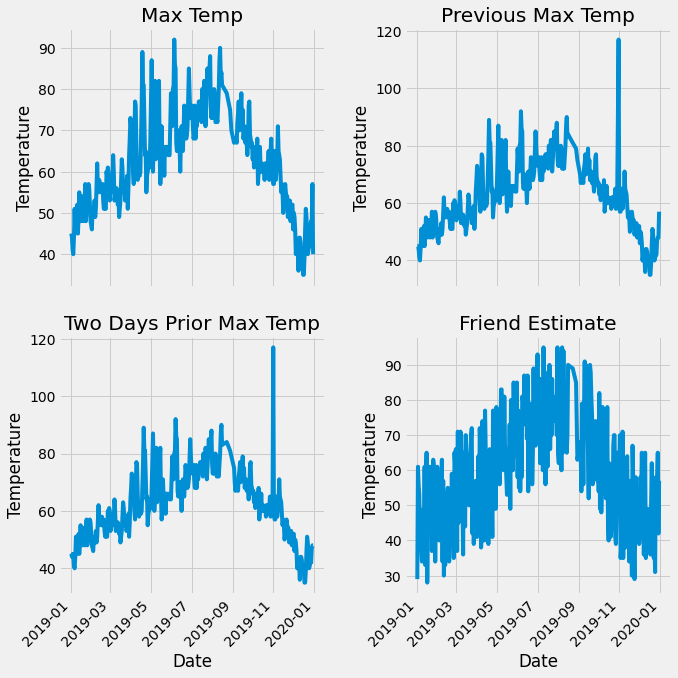

In [30]:
# 准备绘图, 指定绘图风格
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
fig.autofmt_xdate(rotation=45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# 我的逗逼朋友
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')
#tight_layout会自动调整子图参数,使之填充整个图像区域
plt.tight_layout(pad=2)


In [31]:
# 独热编码，将周（字符串）转化成编码的形式
# 简单来讲就是 将所有的可能性列出来, 有的话就是0,没有的话就是1的一个列表
# pd.get_dummies 会将所有不是数值的属性变为one hot编码. 
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2019,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2019,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2019,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2019,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2019,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [32]:
# 标签, 获取所有的y值
labels = np.array(features['actual'])

# 删除标签, drop默认删除行, 需要用axis=1来标识删除的是列
features = features.drop('actual', axis=1)

# 将名字单独保存一下
feature_list = list(features.columns)
feature_list

['year',
 'month',
 'day',
 'temp_2',
 'temp_1',
 'average',
 'friend',
 'week_Fri',
 'week_Mon',
 'week_Sat',
 'week_Sun',
 'week_Thurs',
 'week_Tues',
 'week_Wed']

In [33]:
# 转换成合适的格式, 将pandas的dataframe转换成ndarray的格式
features = np.array(features)
features.shape

(348, 14)

特征工程, 使用sklearn进行标准化操作

In [34]:
## 特征工程
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)
input_features[0] # 标准化的输出是ndarray格式

array([ 0.        , -1.5678393 , -1.65682171, -1.45311448, -1.46252836,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

构建神经网络模型

In [35]:
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16
# 构建神经网络
# 创建一个神经网络序列, 按照序列加载所需要的函数
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size), # 全连接层
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size,output_size)
)
cost = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(my_nn.parameters(),lr=0.001) # 动态调整学习率的优化器


In [36]:
# 开始训练
losses = []
for i in range(1000):
    batch_loss=[]
    ## 使用mini batch来进行训练
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size<len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end],dtype=torch.float,requires_grad=True)
        yy = torch.tensor(labels[start:end],dtype=torch.float,requires_grad=True)
        
        # 直接将x传入模型, 最终会得到预测值
        prediction = my_nn(xx)
        loss = cost(prediction,yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True) # 如果需要重复执行backward操作可以将这个设为true 
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        
    # 打印损失值
    if i%100==0:
        losses.append(np.mean(batch_loss))
        print(i,np.mean(batch_loss))

0 3935.7163
100 38.195896
200 35.619453
300 35.277184
400 35.10499
500 34.962116
600 34.83348
700 34.70787
800 34.57965
900 34.446987


对结果进行预测并展示

In [37]:
x=torch.tensor(input_features,dtype=torch.float)
predict=my_nn(x).data.numpy() ## 直接计算结果


In [38]:
# 转换日期格式 
dates = [str(int(y))+"-"+str(int(m))+"-"+str(int(d)) for y,m,d in zip(year,month,day)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]
# dates[:5]

# 创建一个表格来存放真实的值
true_data = pd.DataFrame(data={'date':dates,'actual':labels})
# 创建一个表格来存储日期和其他对应值的模型预测值
years=features[:,feature_list.index('year')]
months=features[:,feature_list.index('month')]
days=features[:,feature_list.index('day')]
test_dates = [str(int(y))+"-"+str(int(m))+"-"+str(int(d)) for y,m,d in zip(years,months,days)]
test_dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data={'date':test_dates,'prediction':predict.reshape(-1)}) # 这里需要reshape一下,因为需要一列而不是一个矩阵

Text(0.5, 1.0, 'Actual and Predicted Values')

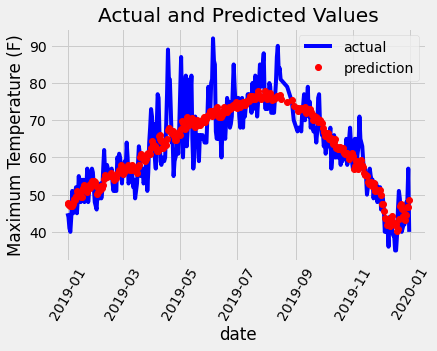

In [41]:
# 真实值
plt.plot(true_data['date'],true_data['actual'],'b-',label='actual')
# 预测值
plt.plot(predictions_data['date'],predictions_data['prediction'],'ro',label='prediction')
plt.xticks(rotation='60')
plt.legend()

plt.xlabel('date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values')